I will make the mantle model more accurate here. I'll first copy the first bits of the code

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import sys
print("imports successful")

grid_count_crust = 640 # would need 637.1 for 20 km spacing
#1275 for 5 km spacing
coordinates = np.linspace(-6371, 6371, grid_count_crust)
grid_1d_size_crust = coordinates[1]-coordinates[0]

# Generate the grid coordinates using meshgrid
x_coordinates, y_coordinates, z_coordinates = np.meshgrid(coordinates, coordinates, coordinates)

# Calculate the distance of each point from the origin using vectorized operations
distances_squared = x_coordinates**2 + y_coordinates**2 + z_coordinates**2

# Find indices where distance is less than or equal to the radius squared
crust_indices = np.logical_and(6350**2 < distances_squared, distances_squared <= 6371**2)

# Extract valid coordinates using boolean indexing
crust_grid = np.stack((x_coordinates[crust_indices], y_coordinates[crust_indices], z_coordinates[crust_indices]), axis=-1)

print("crust grid created successfully")

imports successful
crust grid created successfully


In [90]:
grid_count_mantle = 160 # would need 637.1 for 20 km spacing
#320 for 40 km spacing
#285 for 45 km spacing
#215 for 60km spacing
#160 for 80km spacing
coordinates = np.linspace(-6371, 6371, grid_count_mantle)
grid_1d_size_mantle = coordinates[1]-coordinates[0]

# Generate the grid coordinates using meshgrid
x_coordinates, y_coordinates, z_coordinates = np.meshgrid(coordinates, coordinates, coordinates)

# Calculate the distance of each point from the origin using vectorized operations
distances_squared = x_coordinates**2 + y_coordinates**2 + z_coordinates**2
CLM_indices = np.logical_and(6196**2 < distances_squared, distances_squared <= 6350**2)
CLM_grid = np.stack((x_coordinates[CLM_indices], y_coordinates[CLM_indices], z_coordinates[CLM_indices]), axis=-1)

DM_indices1 = np.logical_and(4202**2 < distances_squared, distances_squared <= 5200**2)
DM_grid1 = np.stack((x_coordinates[DM_indices1], y_coordinates[DM_indices1], z_coordinates[DM_indices1]), axis=-1)

DM_indices2 = np.logical_and(5200**2 < distances_squared, distances_squared <= 6196**2)
DM_grid2 = np.stack((x_coordinates[DM_indices2], y_coordinates[DM_indices2], z_coordinates[DM_indices2]), axis=-1)

EM_indices = np.logical_and(3480**2 < distances_squared, distances_squared <= 4202**2)
EM_grid = np.stack((x_coordinates[EM_indices], y_coordinates[EM_indices], z_coordinates[EM_indices]), axis=-1)

print("mantle grid created successfully")

mantle grid created successfully


We are using this Earth model:

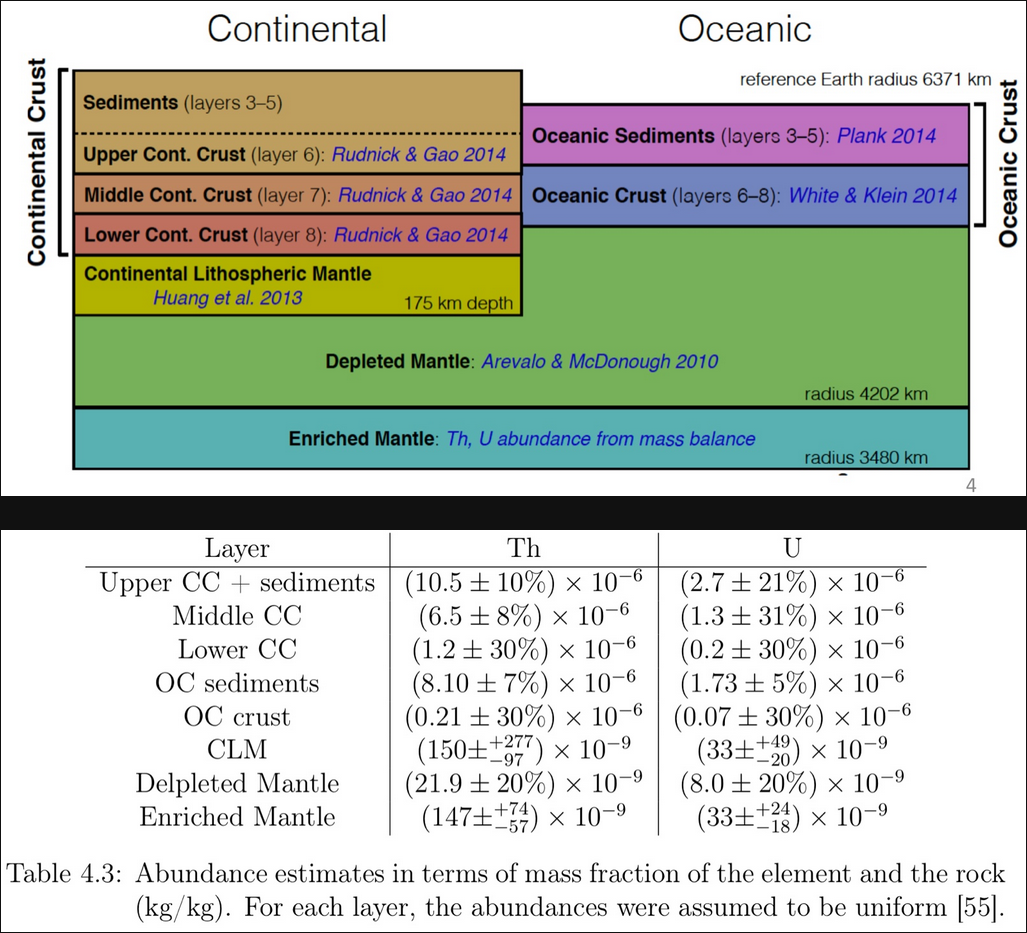

So we will separate the mantle in the following sections: 

    1) Enriched Mantle, from 3480km to 4202 km
    2) Depleted Mantle, from 4202 km to 6371 - 175  = 6196 km
    4) CLM, from 6196 to 6350 (so the remaining bit, the mantle is 20 km)
    5) Mantle, the last 21 km
    
Note that the errors for all of these are quite high, up to almost +200% in CLM and high in other layers as well
    

In [91]:
print("setting densities and abundances")
# Define the parameter sets

# Placeholder definitions for IDE recognition
A_Th_c = A_U_c = A_Th_CLM = A_U_CLM = A_Th_DM1 = A_U_DM1 = A_Th_DM2 = A_U_DM2 = A_Th_EM = A_U_EM = 0

low_abundances = {
    "A_Th_c": 5 * (10**(-6)),
    "A_U_c": 1 * (10**(-6)),
    "A_Th_CLM": 53 * (10**(-9)),
    "A_U_CLM": 13 * (10**(-9)),
    "A_Th_DM": 17.52 * (10**(-9)),
    "A_U_DM": 6.4 * (10**(-9)),
    "A_Th_EM": 90 * (10**(-9)),
    "A_U_EM": 15 * (10**(-9))
}

mid_abundances = {
    "A_Th_c": 5 * (10**(-6)),
    "A_U_c": 1 * (10**(-6)),
    "A_Th_CLM": 147 * (10**(-9)),
    "A_U_CLM": 33 * (10**(-9)),
    "A_Th_DM": 21.9 * (10**(-9)),
    "A_U_DM": 8 * (10**(-9)),
    "A_Th_EM": 147 * (10**(-9)),
    "A_U_EM": 33 * (10**(-9))
}

high_abundances = {
    "A_Th_c": 5 * (10**(-6)),
    "A_U_c": 1 * (10**(-6)),
    "A_Th_CLM": 427 * (10**(-9)),
    "A_U_CLM": 83 * (10**(-9)),
    "A_Th_DM": 26.28 * (10**(-9)),
    "A_U_DM": 9.6 * (10**(-9)),
    "A_Th_EM": 221 * (10**(-9)),
    "A_U_EM": 57 * (10**(-9))
}

# Function to select the parameter set
def select_abundances(abundance_set):
    globals().update(abundance_set)

# Choose the desired parameter set by name
abundances = mid_abundances  # Change to mid_abundances or high_abundances as needed
select_abundances(abundances)



rho_c = 2.7
rho_CLM = 3.3 #g/cm^3 probably
rho_DM = 3.3
rho_EM = 3.3
print("densities and abundances set successfully")

#we have pretty much everything to compute things separately!
# compute for crust
#set position of SNO+

print("setting detector position")

SNO_r = np.array([0, 0, 6369])
# function to calculate relative distance to SNO+ from points in earth grid

setting densities and abundances
densities and abundances set successfully
setting detector position


In [92]:
def calc_relative_dist(points_array):
    # Calculate the Euclidean distance using vectorized operations
    relative_distances = np.linalg.norm(points_array - SNO_r, axis=1)
    
    print("   ")
    print("Computed relative distances from Earth grid points to SNO+")
    print("   ")
    
    return relative_distances

#define Delta function for an array of points and energies
#inputs: appropriate deltam _ij^2, energy array [MeV], points array
#relative distance calculated in km, hence Delta scaled up by a factor of 1000 to account for m-km conversion

def Delta_ij(energy_array, points_array, delta_m_ij_squared):
    # Calculate relative distances
    relative_distance_array = calc_relative_dist(points_array)
    
    # Reshape energy_array to perform element-wise division
    energy_array_reshaped = energy_array.reshape(-1, 1)
    
    # Calculate Delta using vectorized operations
    Delta = (1.27 * delta_m_ij_squared * relative_distance_array * 1000) / (energy_array_reshaped)
    
    return Delta

In [93]:
def P_ee_full_optimized(energy_array, points_array, theta_12, theta_13, delta_m_21_squared):
    
    #P_ee = np.empty((len(energy_array), len(points_array))) # np.empty more efficient
    #than np.zeros or whatever
    #might not need this at all though
    relative_distance_array = calc_relative_dist(points_array)
    
    Delta_31 = Delta_ij(energy_array, points_array, delta_m_31_squared)
    print("Delta_31 computed successfully")
    Delta_12 = Delta_ij(energy_array, points_array, delta_m_21_squared)
    print("Delta_12 computed successfully")

    A = (np.cos(theta_13))**4 * (np.sin(2 * theta_12))**2
    B = np.sin(2 * theta_13)**2

    sin_squared_Delta_31 = np.sin(Delta_31) ** 2
    sin_squared_Delta_12 = np.sin(Delta_12) ** 2
    
    print("values computed successfully")

    P_ee = 1 - (A * sin_squared_Delta_12 + B * sin_squared_Delta_31)
    print("P_ee computed successfully")
    
    return P_ee

In [94]:
#set standard oscillation parameters
print("setting standard oscillation parameters")

theta_12 = 0.5903 #rad
theta_23 = 0.8430 #rad
theta_13 = 0.1503 #rad

delta_m_21_squared = 7.39 * 10**(-5) #eV^2
delta_m_32_squared = 2.449 * 10**(-3) #eV^2
delta_m_31_squared = delta_m_32_squared
print("defining energy array")
energy_array = np.linspace(1.81, 3.31, 30)

setting standard oscillation parameters
defining energy array


In [95]:
## optimized definition of integral, optimized P_ee
def integral_over_positions_Th_U(points_array, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th, A_U, rho):
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    print("Relative distance array computed successfully")
    P_ee_array = P_ee_full_optimized(energy_array, points_array, theta_12, theta_13, delta_m_21_squared)
    print("P_ee_array computed successfully")

    # Compute sum_Th
    sum_Th = np.sum(P_ee_array * ((A_Th * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    
    print("sum_Th computed successfully")
    
    # Compute sum_U
    sum_U = np.sum(P_ee_array * ((A_U * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    print("sum_U computed successfully")

    return sum_Th, sum_U


In [96]:
print("computing integral values for standard oscillation paramaters (crust contribution only)")    
Th_integral_values_c, U_integral_values_c = integral_over_positions_Th_U(crust_grid, energy_array, grid_1d_size_crust, theta_12, delta_m_21_squared, A_Th_c, A_U_c, rho_c)
print("done! moving on")

computing integral values for standard oscillation paramaters (crust contribution only)
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
done! moving on


making plots


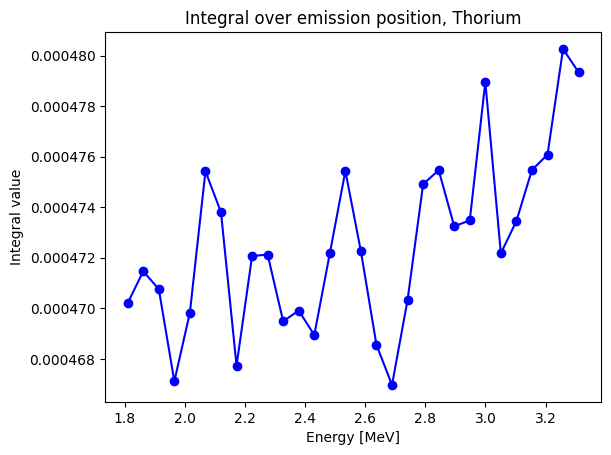

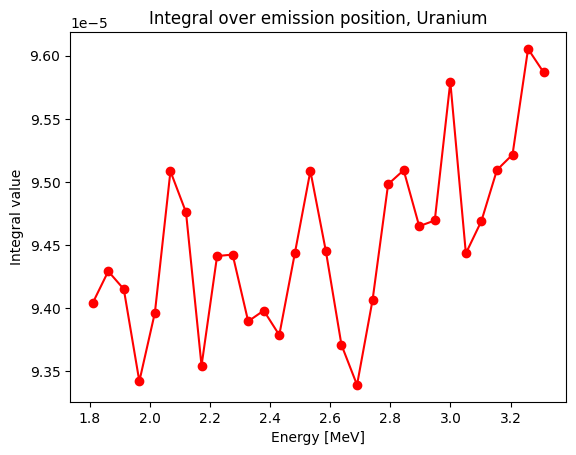

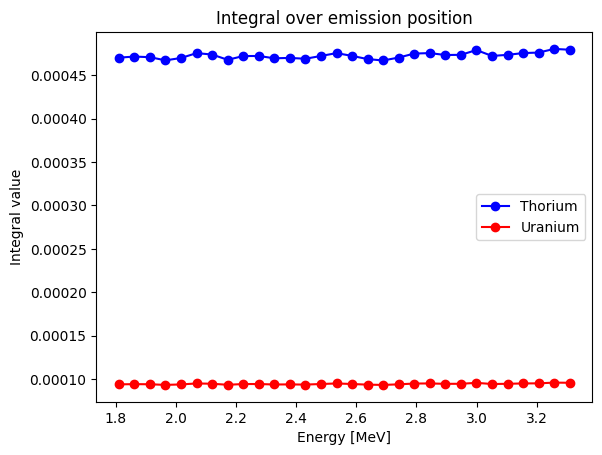

In [97]:
#make plots
print("making plots")
#Thorium
plt.plot(energy_array, Th_integral_values_c, marker='o', linestyle='-', color='b')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
#plt.savefig('Integral over emission position, Thorium, standard oscillation parameters.pdf', format='pdf')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values_c, marker='o', linestyle='-', color='r')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
#plt.savefig('Integral over emission position, Uranium, standard oscillation parameters.pdf', format='pdf')
plt.show()

#Both together

plt.plot(energy_array, Th_integral_values_c, marker='o', linestyle='-', color='b', label='Thorium')
plt.plot(energy_array, U_integral_values_c, marker='o', linestyle='-', color='r', label='Uranium')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position')
plt.legend()
#plt.savefig('Integral over emission position, standard oscillation parameters.pdf', format='pdf')
plt.show()


In [98]:
def integral_over_positions_Th_U_constant_P_ee(points_array, energy_array, grid_1d_size, A_Th, A_U, rho):
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    P_ee_mid = 0.521
    P_ee_stdev = 0.072
    P_ee_low = P_ee_mid - P_ee_stdev
    P_ee_high = P_ee_mid + P_ee_stdev
    P_ee_array_mid = np.full((len(energy_array), len(points_array)), P_ee_mid)
    P_ee_array_low = np.full((len(energy_array), len(points_array)), P_ee_low)
    P_ee_array_high = np.full((len(energy_array), len(points_array)), P_ee_high)
    
    
    # Compute sum_Th
    sum_mid_Th = np.sum(P_ee_array_mid * ((A_Th * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    sum_low_Th = np.sum(P_ee_array_low * ((A_Th * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    sum_high_Th = np.sum(P_ee_array_high * ((A_Th * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    
    # Compute sum_U
    sum_mid_U = np.sum(P_ee_array_mid * ((A_U * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    sum_low_U = np.sum(P_ee_array_low * ((A_U * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    sum_high_U = np.sum(P_ee_array_high * ((A_U * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)

    return sum_mid_Th, sum_mid_U, sum_low_Th, sum_low_U, sum_high_Th, sum_high_U

In [99]:
print("computing integral values for standard P_ee (crust contribution only")
Th_integral_values_constant_P_ee_mid_c, U_integral_values_constant_P_ee_mid_c, Th_integral_values_constant_P_ee_low_c, U_integral_values_constant_P_ee_low_c, Th_integral_values_constant_P_ee_high_c, U_integral_values_constant_P_ee_high_c = integral_over_positions_Th_U_constant_P_ee (crust_grid, energy_array, grid_1d_size_crust, A_Th_c, A_U_c, rho_c)
print("done! moving on")

computing integral values for standard P_ee (crust contribution only
   
Computed relative distances from Earth grid points to SNO+
   
done! moving on


making plots


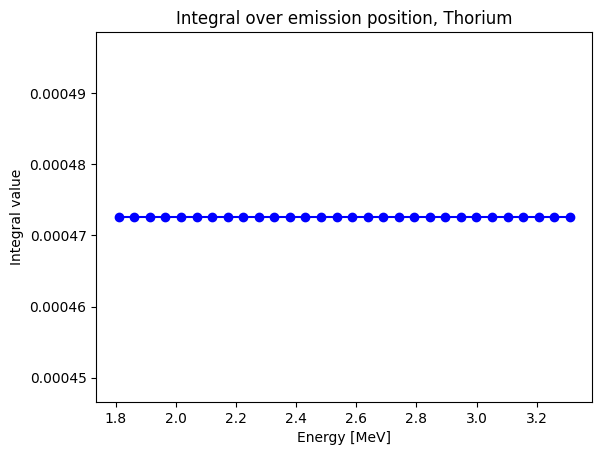

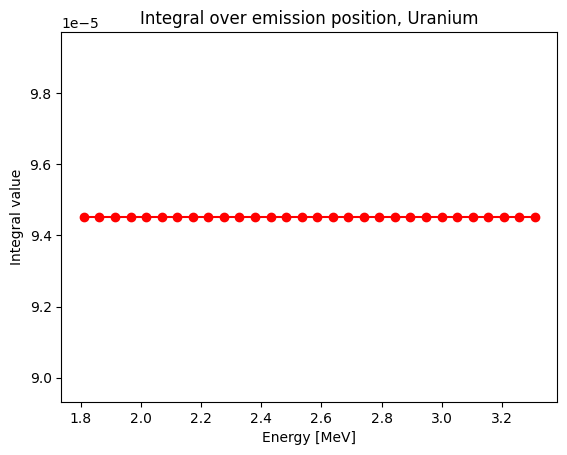

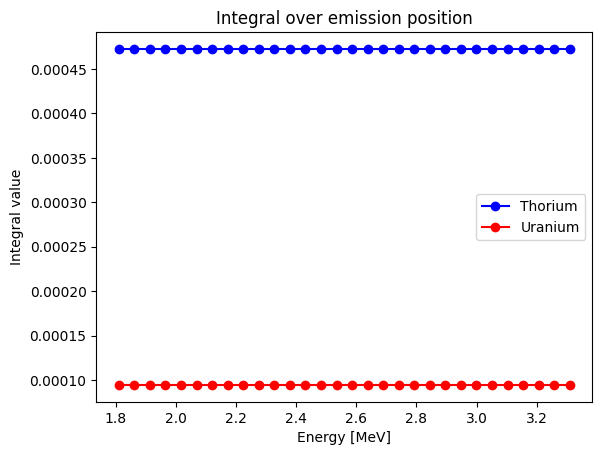

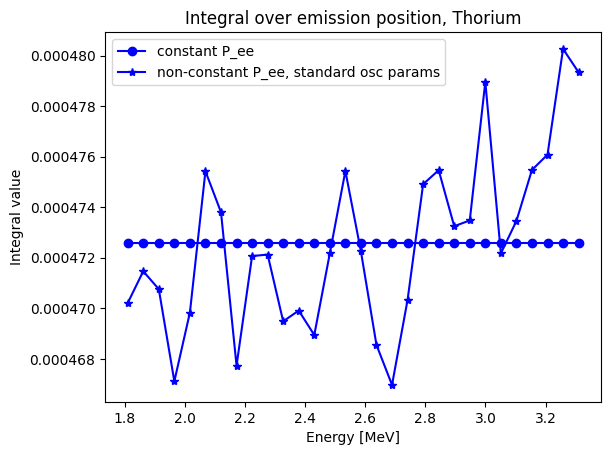

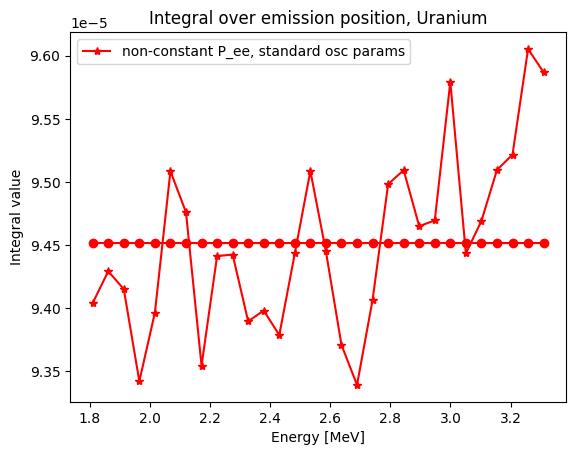

In [100]:
#make plots, just for integrals with constant P_ee
print("making plots")
#Thorium
plt.plot(energy_array, Th_integral_values_constant_P_ee_mid_c, marker='o', linestyle='-', color='b')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values_constant_P_ee_mid_c, marker='o', linestyle='-', color='r')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
plt.show()

#Both together

plt.plot(energy_array, Th_integral_values_constant_P_ee_mid_c, marker='o', linestyle='-', color='b', label='Thorium')
plt.plot(energy_array, U_integral_values_constant_P_ee_mid_c, marker='o', linestyle='-', color='r', label='Uranium')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position')
plt.legend()
plt.show()
#make plots to compare integral for constant P_ee and non-constant(dependent on energy and oscillation parameters)

#Thorium
plt.plot(energy_array, Th_integral_values_constant_P_ee_mid_c, marker='o', linestyle='-', color='b', label='constant P_ee')
plt.plot(energy_array, Th_integral_values_c, marker='*', linestyle='-', color='b', label='non-constant P_ee, standard osc params')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
plt.legend()
#plt.savefig('Thorium Integral, standard osc params vs constant P_ee.pdf', format='pdf')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values_constant_P_ee_mid_c, marker='o', linestyle='-', color='r')
plt.plot(energy_array, U_integral_values_c, marker='*', linestyle='-', color='r', label = 'non-constant P_ee, standard osc params')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
plt.legend()
#plt.savefig('Uranium Integral, standard osc params vs constant P_ee.pdf', format='pdf')
plt.show()


In [101]:
def sigma_IBD(energy_array):
    # optimized with numpy
    
    m_e = 0.511 #MeV
    m_p = 938 #MeV
    m_n = 941 #MeV
    E_th = 1.8 #MeV
    
    sigma = ((energy_array - E_th + m_e)**2) * ((1 - (m_e)**2/((energy_array - E_th + m_e)**2))**(1/2))
    
    return sigma
#all these + sources in Earth model more bins -3 (for example)


In [102]:
print("setting lambda and mu values")

lambda_U = 4.916
lambda_Th = 1.563
mu_U = 235
mu_Th = 232

setting lambda and mu values


getting emission fluxes


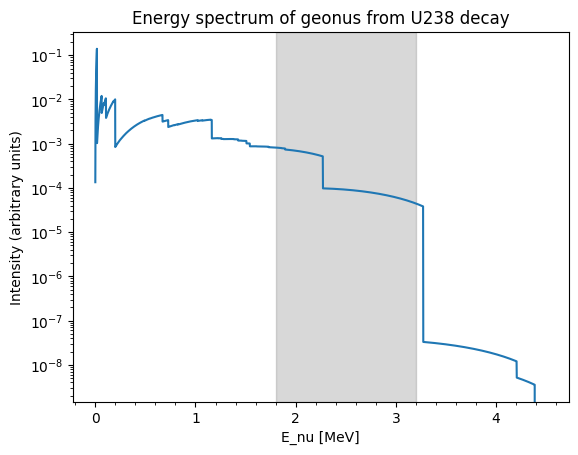

done for Uranium, moving on to Thorium


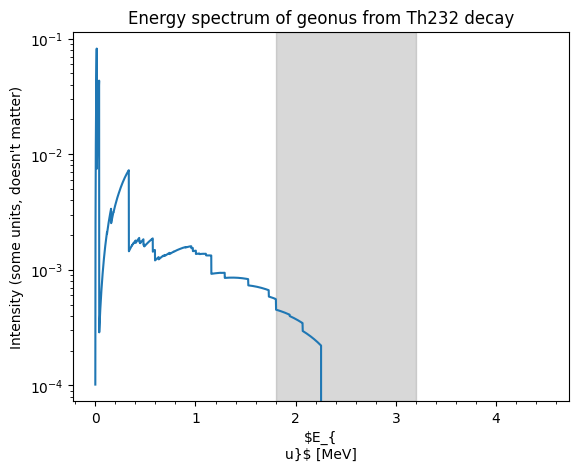

rebin to match energy array


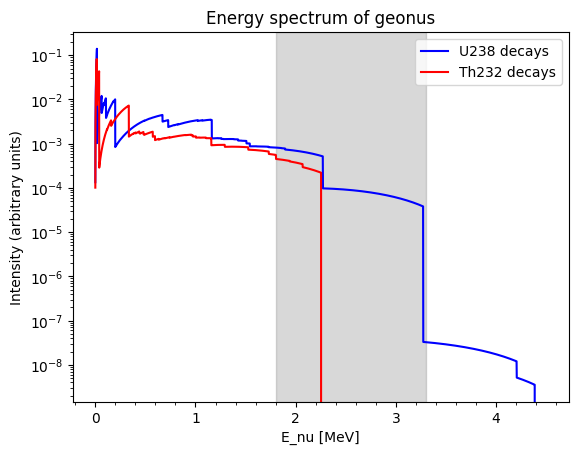

In [103]:

#get fluxes
print("getting emission fluxes")
energy_array_U = []
dn_dE_U = []

with open('U238_spectrum.txt', 'r') as file:
    for line in file:
        # Split each line into columns
        columns = line.split()

        # Convert the elements to float and append to arrays
        energy_array_U.append(float(columns[0]))
        dn_dE_U.append(float(columns[1]))

# Scale down all energies by a factor of 1000
energy_array_U = np.array(energy_array_U) / 1000
dn_dE_U = np.array(dn_dE_U)

plt.plot(energy_array_U, dn_dE_U)
plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (arbitrary units)')
plt.title('Energy spectrum of geonus from U238 decay')
# 
# Add shaded region between 1.8 MeV and 3.2 MeV
plt.axvspan(1.8, 3.2, alpha=0.3, color='gray')
# Enable minor ticks on x-axis
plt.minorticks_on()
plt.savefig("Emission.pdf", format='pdf')
plt.show()

print("done for Uranium, moving on to Thorium")

energy_array_Th = []
dn_dE_Th = []
with open('Th232_spectrum.txt', 'r') as file:
    for line in file:
        # Split each line into columns
        columns = line.split()

        # Convert the elements to float and append to arrays
        energy_array_Th.append(float(columns[0]))
        dn_dE_Th.append(float(columns[1]))

# Scale down all energies by a factor of 1000
energy_array_Th = np.array(energy_array_Th) / 1000
dn_dE_Th = np.array(dn_dE_Th)

plt.plot(energy_array_Th, dn_dE_Th)
plt.xlabel('$E_{\nu}$ [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (some units, doesn\'t matter)')
plt.title('Energy spectrum of geonus from Th232 decay')
# # Add shaded region between 1.8 MeV and 3.2 MeV
plt.axvspan(1.8, 3.2, alpha=0.3, color='gray')
# # Enable minor ticks on x-axis
plt.minorticks_on()
plt.show()
# Plot U238 decay data (blue line)
plt.plot(energy_array_U, dn_dE_U, label='U238 decays', color='blue')
# 
# # Plot Th232 decay data (red line)
plt.plot(energy_array_Th, dn_dE_Th, label='Th232 decays', color='red')
# 
plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (arbitrary units)')
plt.title('Energy spectrum of geonus')
# 
# # Add shaded region between 1.8 MeV and 3.3 MeV
plt.axvspan(1.8, 3.3, alpha=0.3, color='gray')
# 
# # Enable minor ticks on x-axis
plt.minorticks_on()
# 
plt.legend(loc='upper right')
# 
#plt.show()

plt.savefig("Emission.pdf", format='pdf')
def rebin_counts(initial_bins, counts_in_initial_bins, final_bin_midpoints):
    """
    Rebins counts data.

    Parameters:
    - initial_bins: array, bin edges of the initial data
    - counts_in_initial_bins: array, counts in each initial bin
    - final_bin_midpoints: array, midpoints of the final desired bins

    Returns:
    - counts_in_final_bins: array, counts in each final bin
    """

    # Calculate bin midpoints of the initial bins
    bin_midpoints = (initial_bins[:-1] + initial_bins[1:]) / 2

    # Use np.histogram to calculate counts in final bins
    counts_in_final_bins, _ = np.histogram(initial_bins, bins=np.concatenate([initial_bins, [2 * initial_bins[-1] - initial_bins[-2]]]), weights=counts_in_initial_bins)

    # Interpolate the counts to the final bin midpoints
    counts_in_final_bins = np.interp(final_bin_midpoints, bin_midpoints, counts_in_final_bins[:-1])

    return counts_in_final_bins

print("rebin to match energy array")

dn_dE_rebinned_U = rebin_counts(energy_array_U, dn_dE_U, energy_array)
dn_dE_rebinned_Th = rebin_counts(energy_array_Th, dn_dE_Th, energy_array)
# compute total fluxes, coming from crust only

In [104]:
print("computing IBD cross section")
sigma = sigma_IBD(energy_array)

computing IBD cross section


In [105]:
print("computing fluxes at detector (standard oscillation parameters, crust contribution only")
N_Th_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_c
N_U_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_c
   

computing fluxes at detector (standard oscillation parameters, crust contribution only


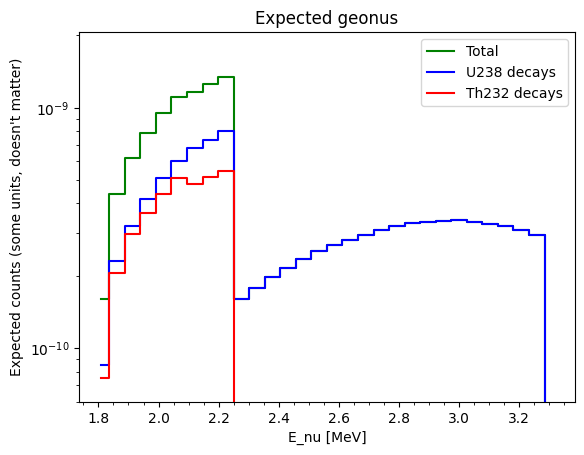

In [106]:
# Plot histogram for both
plt.step(energy_array, N_U_c + N_Th_c, where='mid', label='Total', color='green')
plt.step(energy_array, N_U_c, where='mid', label='U238 decays', color='blue')
plt.step(energy_array, N_Th_c, where='mid', label='Th232 decays', color='red')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=6e-11)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()


In [107]:
print("computing fluxes at detector (constant P_ee, crust contribution only")
N_Th_constant_P_ee_mid_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_constant_P_ee_mid_c
N_U_constant_P_ee_mid_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_constant_P_ee_mid_c
    
N_Th_constant_P_ee_low_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_constant_P_ee_low_c
N_U_constant_P_ee_low_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_constant_P_ee_low_c
    
N_Th_constant_P_ee_high_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_constant_P_ee_high_c
N_U_constant_P_ee_high_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_constant_P_ee_high_c
    

computing fluxes at detector (constant P_ee, crust contribution only


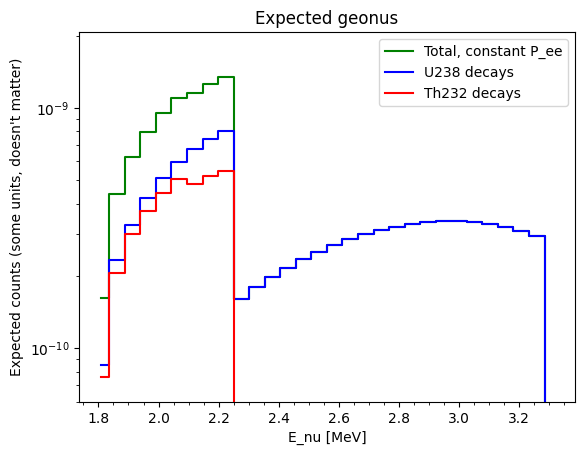

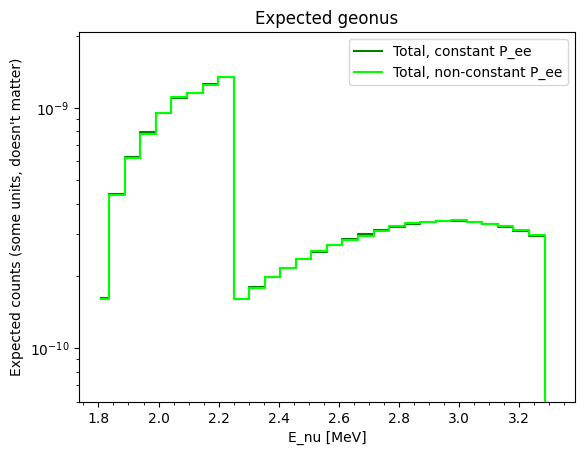

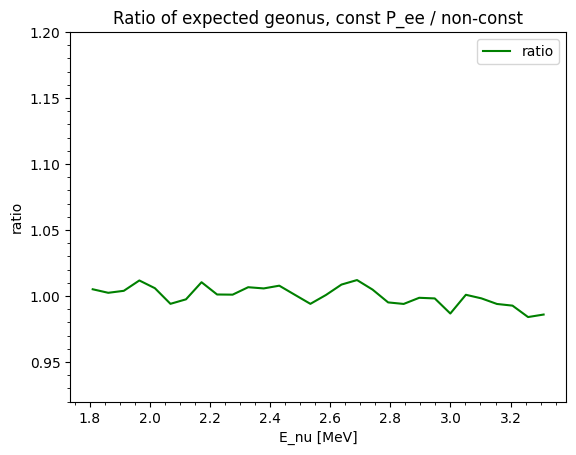

N_U_c + N_Th_c : [1.60278818e-10 4.36160285e-10 6.20535345e-10 7.82380027e-10
 9.48769367e-10 1.10918634e-09 1.15876939e-09 1.25000777e-09
 1.34619185e-09 1.60689085e-10 1.78340199e-10 1.97080604e-10
 2.15004364e-10 2.34542209e-10 2.53685411e-10 2.68495774e-10
 2.81632218e-10 2.94476826e-10 3.08831540e-10 3.22254607e-10
 3.30865968e-10 3.35093770e-10 3.38377193e-10 3.42572712e-10
 3.34976264e-10 3.29988758e-10 3.22222661e-10 3.10107868e-10
 2.96622910e-10 2.56941323e-13]


In [108]:
# Plot histogram for both, constant P_ee only
plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c, where='mid', label='Total, constant P_ee', color='green')
plt.step(energy_array, N_U_constant_P_ee_mid_c, where='mid', label='U238 decays', color='blue')
plt.step(energy_array, N_Th_constant_P_ee_mid_c, where='mid', label='Th232 decays', color='red')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=6e-11)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()
#plot to compare total for constant P_ee vs non-constant P_ee with standard osc parameters

plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c, where='mid', label='Total, constant P_ee', color='green')
plt.step(energy_array, N_U_c + N_Th_c, where='mid', label='Total, non-constant P_ee', color='lime')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=6e-11)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#plt.savefig('Expected counts, standard params vs constant P_ee.pdf', format='pdf')

plt.show()


plt.plot(energy_array, (N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c) / (N_U_c + N_Th_c), label='ratio', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, const P_ee / non-const')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-12)
# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#plt.savefig('Ratio of expected geonus, standard params vs constant P_ee.pdf', format='pdf')

plt.show()

print(f'N_U_c + N_Th_c : {N_U_c + N_Th_c}')
# we did this for the crust, now want to do this for the mantle as well
# mantle grid too big, restrict distances
# adjust size as required




In [109]:
print("Now getting into the complicated stuff")
print("Starting mantle contribution calculations ... ")

print("len(CLM_grid) : " + str(len(CLM_grid)))
print("len(DM_grid1) : " + str(len(DM_grid1)))
print("len(DM_grid2) : " + str(len(DM_grid2)))
print("len(EM_grid) : " + str(len(EM_grid)))

Now getting into the complicated stuff
Starting mantle contribution calculations ... 
len(CLM_grid) : 147128
len(DM_grid1) : 540176
len(DM_grid2) : 791944
len(EM_grid) : 260560


In [110]:
print("computing integrals for standard oscillation parameters, CLM contribution only")

Th_integral_values_CLM, U_integral_values_CLM = integral_over_positions_Th_U(CLM_grid, energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_CLM, A_U_CLM, rho_CLM)




computing integrals for standard oscillation parameters, CLM contribution only
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully


In [111]:
print("computing integrals for standard oscillation parameters, DM contribution only")

Th_integral_values_DM1, U_integral_values_DM1= integral_over_positions_Th_U(DM_grid1, energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM2, U_integral_values_DM2 = integral_over_positions_Th_U(DM_grid2, energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM = Th_integral_values_DM1 + Th_integral_values_DM2
U_integral_values_DM = U_integral_values_DM1 + U_integral_values_DM2

computing integrals for standard oscillation parameters, DM contribution only
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
Delta_12 computed successfully
values computed successf

In [112]:

print("computing integrals for standard oscillation parameters, EM contribution only")

Th_integral_values_EM, U_integral_values_EM = integral_over_positions_Th_U(EM_grid, energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)

computing integrals for standard oscillation parameters, EM contribution only
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully


In [113]:
print(" computing total contribution ")
Th_integral_values_m = Th_integral_values_CLM + Th_integral_values_EM + Th_integral_values_DM
U_integral_values_m = U_integral_values_CLM + U_integral_values_EM + U_integral_values_DM

 computing total contribution 


In [114]:
print("computing integrals for constant P_ee, CLM contribution only")
Th_integral_values_constant_P_ee_mid_CLM, U_integral_values_constant_P_ee_mid_CLM, Th_integral_values_constant_P_ee_low_CLM, U_integral_values_constant_P_ee_low_CLM, Th_integral_values_constant_P_ee_high_CLM, U_integral_values_constant_P_ee_high_CLM = integral_over_positions_Th_U_constant_P_ee (CLM_grid, energy_array, grid_1d_size_mantle, A_Th_CLM, A_U_CLM, rho_CLM)


computing integrals for constant P_ee, CLM contribution only
   
Computed relative distances from Earth grid points to SNO+
   


In [115]:

print("computing integrals for constant P_ee, DM contribution only")

Th_integral_values_constant_P_ee_mid_DM1, U_integral_values_constant_P_ee_mid_DM1, Th_integral_values_constant_P_ee_low_DM1, U_integral_values_constant_P_ee_low_DM1, Th_integral_values_constant_P_ee_high_DM1, U_integral_values_constant_P_ee_high_DM1= integral_over_positions_Th_U_constant_P_ee(DM_grid1, energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)
Th_integral_values_constant_P_ee_mid_DM2, U_integral_values_constant_P_ee_mid_DM2, Th_integral_values_constant_P_ee_low_DM2, U_integral_values_constant_P_ee_low_DM2, Th_integral_values_constant_P_ee_high_DM2, U_integral_values_constant_P_ee_high_DM2= integral_over_positions_Th_U_constant_P_ee(DM_grid2, energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM = Th_integral_values_constant_P_ee_mid_DM1 + Th_integral_values_constant_P_ee_mid_DM2

Th_integral_values_constant_P_ee_low_DM = Th_integral_values_constant_P_ee_low_DM1 + Th_integral_values_constant_P_ee_low_DM2

Th_integral_values_constant_P_ee_high_DM = Th_integral_values_constant_P_ee_high_DM1 + Th_integral_values_constant_P_ee_high_DM2

U_integral_values_constant_P_ee_mid_DM = U_integral_values_constant_P_ee_mid_DM1 + U_integral_values_constant_P_ee_mid_DM2

U_integral_values_constant_P_ee_low_DM = U_integral_values_constant_P_ee_low_DM1 + U_integral_values_constant_P_ee_low_DM2

U_integral_values_constant_P_ee_high_DM = U_integral_values_constant_P_ee_high_DM1 + U_integral_values_constant_P_ee_high_DM2




computing integrals for constant P_ee, DM contribution only
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   


In [116]:
print("computing integrals for constant P_ee, EM contribution only")

Th_integral_values_constant_P_ee_mid_EM, U_integral_values_constant_P_ee_mid_EM, Th_integral_values_constant_P_ee_low_EM, U_integral_values_constant_P_ee_low_EM, Th_integral_values_constant_P_ee_high_EM, U_integral_values_constant_P_ee_high_EM = integral_over_positions_Th_U_constant_P_ee(
    EM_grid, energy_array, grid_1d_size_mantle, A_Th_EM, A_U_EM, rho_EM)



computing integrals for constant P_ee, EM contribution only
   
Computed relative distances from Earth grid points to SNO+
   


In [117]:
print(" computing total contribution ")

Th_integral_values_constant_P_ee_mid_m = Th_integral_values_constant_P_ee_mid_CLM + Th_integral_values_constant_P_ee_mid_DM + Th_integral_values_constant_P_ee_mid_EM
Th_integral_values_constant_P_ee_low_m = Th_integral_values_constant_P_ee_low_CLM + Th_integral_values_constant_P_ee_low_DM + Th_integral_values_constant_P_ee_low_EM
Th_integral_values_constant_P_ee_high_m = Th_integral_values_constant_P_ee_high_CLM + Th_integral_values_constant_P_ee_high_DM + Th_integral_values_constant_P_ee_high_EM

U_integral_values_constant_P_ee_mid_m = U_integral_values_constant_P_ee_mid_CLM + U_integral_values_constant_P_ee_mid_DM + U_integral_values_constant_P_ee_mid_EM
U_integral_values_constant_P_ee_low_m = U_integral_values_constant_P_ee_low_CLM + U_integral_values_constant_P_ee_low_DM + U_integral_values_constant_P_ee_low_EM
U_integral_values_constant_P_ee_high_m = U_integral_values_constant_P_ee_high_CLM + U_integral_values_constant_P_ee_high_DM + U_integral_values_constant_P_ee_high_EM

 computing total contribution 


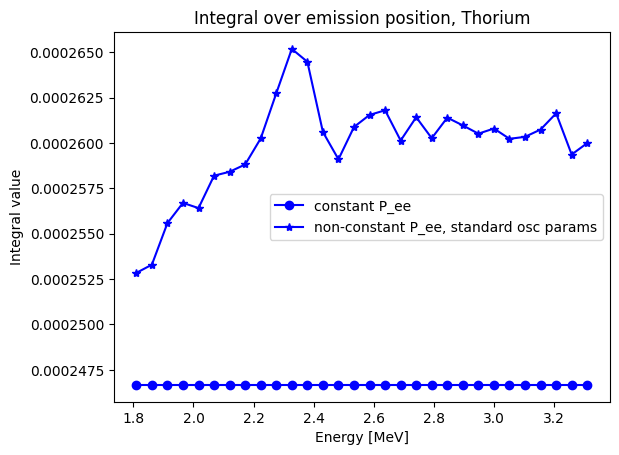

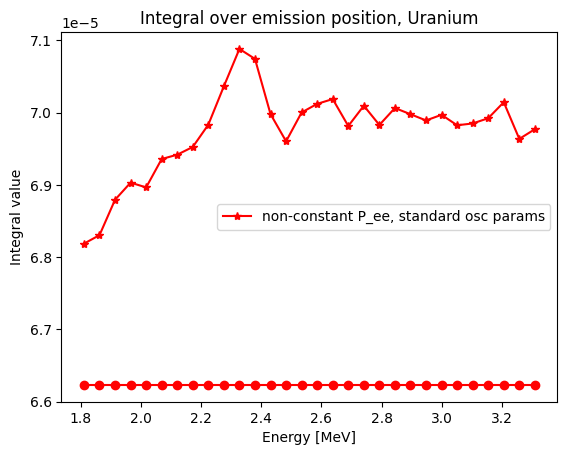

In [118]:
#make plots to compare integral for constant P_ee and non-constant(dependent on energy and oscillation parameters)

#Thorium
plt.plot(energy_array, Th_integral_values_constant_P_ee_mid_m, marker='o', linestyle='-', color='b', label='constant P_ee')
plt.plot(energy_array, Th_integral_values_m, marker='*', linestyle='-', color='b', label='non-constant P_ee, standard osc params')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
plt.legend()
#plt.savefig('Thorium Integral, standard osc params vs constant P_ee.pdf', format='pdf')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values_constant_P_ee_mid_m, marker='o', linestyle='-', color='r')
plt.plot(energy_array, U_integral_values_m, marker='*', linestyle='-', color='r', label = 'non-constant P_ee, standard osc params')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
plt.legend()
#plt.savefig('Uranium Integral, standard osc params vs constant P_ee.pdf', format='pdf')
plt.show()


In [86]:
print("computing fluxes at detector location")

N_Th_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_m
N_U_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_m

N_Th_constant_P_ee_mid_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_constant_P_ee_mid_m
N_U_constant_P_ee_mid_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_constant_P_ee_mid_m

N_Th_constant_P_ee_low_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_constant_P_ee_low_m
N_U_constant_P_ee_low_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_constant_P_ee_low_m

N_Th_constant_P_ee_high_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_constant_P_ee_high_m
N_U_constant_P_ee_high_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_constant_P_ee_high_m


computing fluxes at detector location


plotting comparison between constant P_ee and standard oscillation parameters


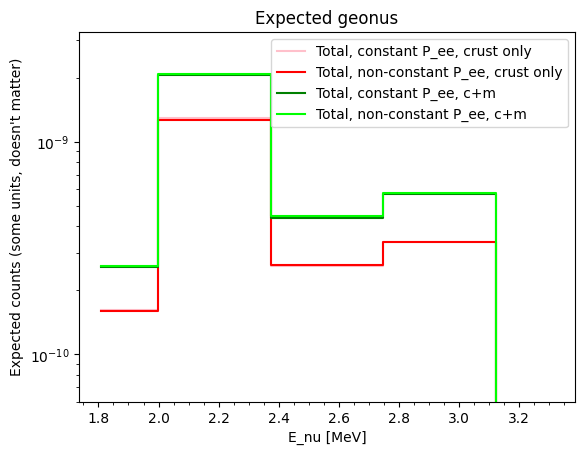

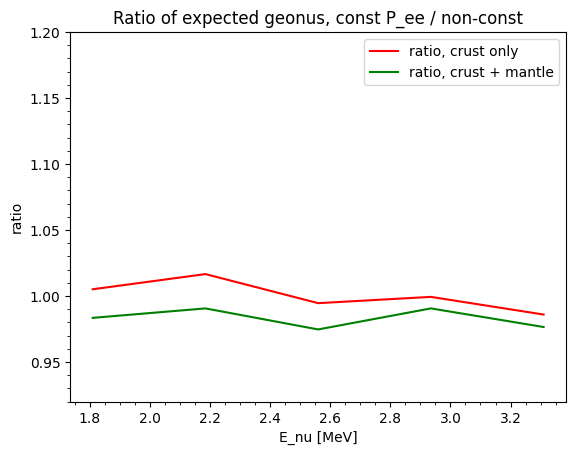

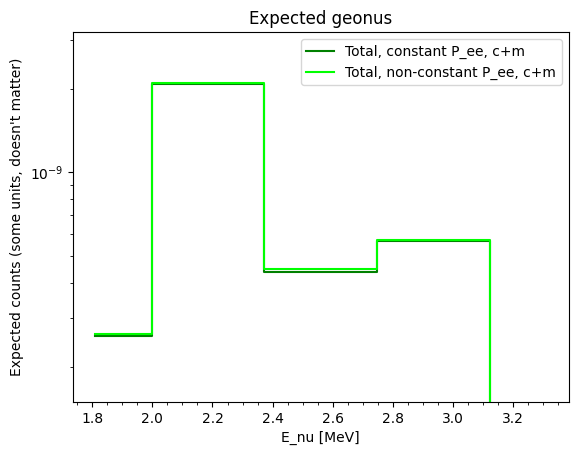

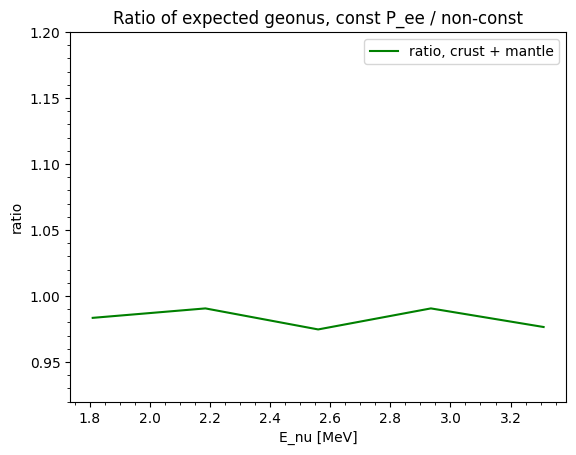

plots saved


In [87]:

#plot to compare total for constant P_ee vs non-constant P_ee with standard osc parameters

print("plotting comparison between constant P_ee and standard oscillation parameters")

plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c, where='mid', label='Total, constant P_ee, crust only', color='pink')
plt.step(energy_array, N_U_c + N_Th_c, where='mid', label='Total, non-constant P_ee, crust only', color='red')
plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m, where='mid', label='Total, constant P_ee, c+m', color='green')
plt.step(energy_array, N_U_c + N_Th_c + N_U_m + N_Th_m, where='mid', label='Total, non-constant P_ee, c+m', color='lime')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=6e-11)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#crust versus crust+mantle comparison
plt.savefig('Expected counts, standard params vs constant P_ee, Detailed Mantle.pdf', format='pdf')

plt.show()


plt.plot(energy_array, (N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c) / (N_U_c + N_Th_c), label='ratio, crust only', color='red')
plt.plot(energy_array, (N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio, crust + mantle', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, const P_ee / non-const')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#crust versus crust+mantle comparison
plt.savefig('Ratio of expected geonus, standard params vs constant P_ee, comparison, Detailed Mantle.pdf', format='pdf')

plt.show()


plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m, where='mid', label='Total, constant P_ee, c+m', color='green')
plt.step(energy_array, N_U_c + N_Th_c + N_U_m + N_Th_m, where='mid', label='Total, non-constant P_ee, c+m', color='lime')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=1.5e-10)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#crust versus crust+mantle comparison
plt.savefig('Expected counts, standard params vs constant P_ee, Detailed Mantle.pdf', format='pdf')

plt.show()


plt.plot(energy_array, (N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio, crust + mantle', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, const P_ee / non-const')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#constant P_ee versus standard oscillation parameters
#plt.savefig('Ratio of expected geonus, standard params vs constant P_ee, Detailed Mantle.pdf', format='pdf')

plt.show()

print("plots saved")

plotting comparison between constant P_ee and standard oscillation parameters


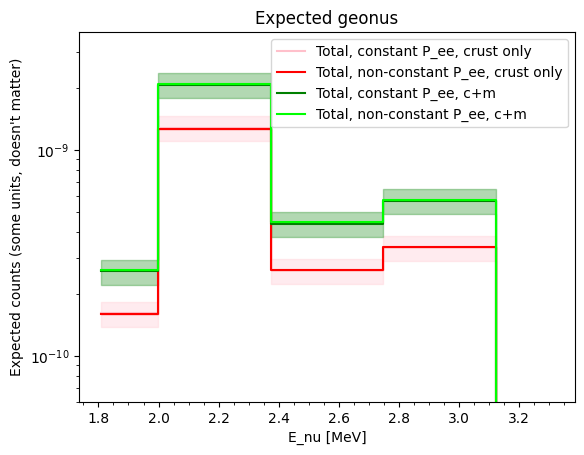

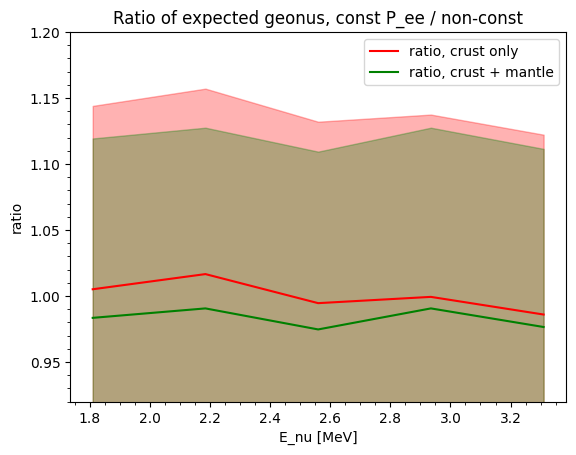

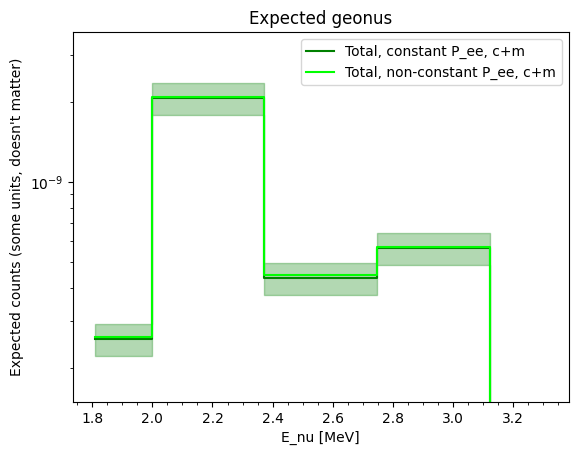

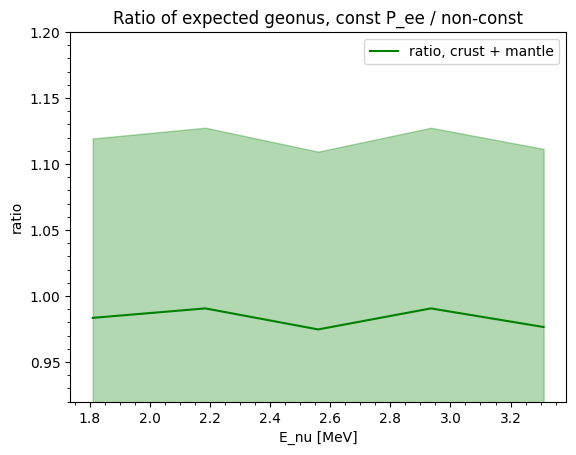

plots saved


In [88]:
print("plotting comparison between constant P_ee and standard oscillation parameters")

# First plot with shaded bands
plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c, where='mid', label='Total, constant P_ee, crust only', color='pink')
plt.fill_between(energy_array, N_U_constant_P_ee_low_c + N_Th_constant_P_ee_low_c, N_U_constant_P_ee_high_c + N_Th_constant_P_ee_high_c, step='mid', color='pink', alpha=0.3)
plt.step(energy_array, N_U_c + N_Th_c, where='mid', label='Total, non-constant P_ee, crust only', color='red')
plt.fill_between(energy_array, N_U_c + N_Th_c, N_U_c + N_Th_c, step='mid', color='red', alpha=0.3)
plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m, where='mid', label='Total, constant P_ee, c+m', color='green')
plt.fill_between(energy_array, N_U_constant_P_ee_low_c + N_Th_constant_P_ee_low_c + N_U_constant_P_ee_low_m + N_Th_constant_P_ee_low_m, N_U_constant_P_ee_high_c + N_Th_constant_P_ee_high_c + N_U_constant_P_ee_high_m + N_Th_constant_P_ee_high_m, step='mid', color='green', alpha=0.3)
plt.step(energy_array, N_U_c + N_Th_c + N_U_m + N_Th_m, where='mid', label='Total, non-constant P_ee, c+m', color='lime')
plt.fill_between(energy_array, N_U_c + N_Th_c + N_U_m + N_Th_m, N_U_c + N_Th_c + N_U_m + N_Th_m, step='mid', color='lime', alpha=0.3)

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=6e-11)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

# Save figure
#plt.savefig('Expected counts, standard params vs constant P_ee, Detailed Mantle.pdf', format='pdf')

plt.show()

# Second plot with shaded bands
plt.plot(energy_array, (N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c) / (N_U_c + N_Th_c), label='ratio, crust only', color='red')
plt.fill_between(energy_array, (N_U_constant_P_ee_low_c + N_Th_constant_P_ee_low_c) / (N_U_c + N_Th_c), (N_U_constant_P_ee_high_c + N_Th_constant_P_ee_high_c) / (N_U_c + N_Th_c), color='red', alpha=0.3)
plt.plot(energy_array, (N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio, crust + mantle', color='green')
plt.fill_between(energy_array, (N_U_constant_P_ee_low_c + N_Th_constant_P_ee_low_c + N_U_constant_P_ee_low_m + N_Th_constant_P_ee_low_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), (N_U_constant_P_ee_high_c + N_Th_constant_P_ee_high_c + N_U_constant_P_ee_high_m + N_Th_constant_P_ee_high_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), color='green', alpha=0.3)
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, const P_ee / non-const')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

# Save figure
#plt.savefig('Ratio of expected geonus, standard params vs constant P_ee, comparison, Detailed Mantle.pdf', format='pdf')

plt.show()

# Third plot with shaded bands
plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m, where='mid', label='Total, constant P_ee, c+m', color='green')
plt.fill_between(energy_array, N_U_constant_P_ee_low_c + N_Th_constant_P_ee_low_c + N_U_constant_P_ee_low_m + N_Th_constant_P_ee_low_m, N_U_constant_P_ee_high_c + N_Th_constant_P_ee_high_c + N_U_constant_P_ee_high_m + N_Th_constant_P_ee_high_m, step='mid', color='green', alpha=0.3)
plt.step(energy_array, N_U_c + N_Th_c + N_U_m + N_Th_m, where='mid', label='Total, non-constant P_ee, c+m', color='lime')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=1.5e-10)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

# Save figure
#plt.savefig('Expected counts, standard params vs constant P_ee, Detailed Mantle.pdf', format='pdf')

plt.show()

# Fourth plot with shaded bands
plt.plot(energy_array, (N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio, crust + mantle', color='green')
plt.fill_between(energy_array, (N_U_constant_P_ee_low_c + N_Th_constant_P_ee_low_c + N_U_constant_P_ee_low_m + N_Th_constant_P_ee_low_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), (N_U_constant_P_ee_high_c + N_Th_constant_P_ee_high_c + N_U_constant_P_ee_high_m + N_Th_constant_P_ee_high_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), color='green', alpha=0.3)
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, const P_ee / non-const')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

# Save figure
#plt.savefig('Ratio of expected geonus, standard params vs constant P_ee, Detailed Mantle.pdf', format='pdf')

plt.show()

print("plots saved")

In [34]:
def integral_over_pos_weights(points_array, energy_array, grid_1d_size, A_Th, A_U, rho):
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
 
    # Compute sum_Th and sum_U
    sum_Th = np.sum(((A_Th * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    sum_U = np.sum(((A_U * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    
    return sum_Th, sum_U
    

In [35]:
w_sum_Th_c, w_sum_U_c = integral_over_pos_weights(crust_grid, energy_array, grid_1d_size_crust, A_Th_c, A_U_c, rho_c)
w_sum_Th_c, w_sum_U_c = integral_over_pos_weights(crust_grid, energy_array, grid_1d_size_mantle, A_Th_c, A_U_c, rho_c)

In [36]:
print("setting alternative oscillation parameters")

theta_12_low = theta_12 * 0.9 #rad; do +- 10% now
print("theta_12_low: " + str(theta_12_low))
theta_12_high = theta_12 * 1.1
print("theta_12_high: " + str(theta_12_high))

#delta_m_21_squared_low = 5 * 10**(-5) #eV^2
delta_m_21_squared_low = delta_m_21_squared - 0.2 * 10**(-5)
print("delta_m_21_squared_low: " + str(delta_m_21_squared_low))
#delta_m_21_squared_high = 1.2 * 10**(-4)
delta_m_21_squared_high = delta_m_21_squared + 0.21 * 10**(-5)
print("delta_m_21_squared_high: " + str(delta_m_21_squared_high))


setting alternative oscillation parameters
theta_12_low: 0.53127
theta_12_high: 0.6493300000000001
delta_m_21_squared_low: 7.190000000000001e-05
delta_m_21_squared_high: 7.6e-05


In [37]:
print("computing contribution from crust for low theta")
Th_integral_values_theta_low_c, U_integral_values_theta_low_c = integral_over_positions_Th_U(crust_grid, energy_array, grid_1d_size_crust, theta_12_low, delta_m_21_squared, A_Th_c, A_U_c, rho_c)
print("done!! moving on ...")

computing contribution from crust for low theta
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
done!! moving on ...


In [38]:
print("computing contribution from CLM for low theta")
Th_integral_values_theta_low_CLM, U_integral_values_theta_low_CLM = integral_over_positions_Th_U(CLM_grid, energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_CLM, A_U_CLM, rho_CLM)

computing contribution from CLM for low theta
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully


In [39]:
print("computing contribution from DM for low theta")
Th_integral_values_theta_low_DM1, U_integral_values_theta_low_DM1 = integral_over_positions_Th_U(DM_grid1, energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM2, U_integral_values_theta_low_DM2 = integral_over_positions_Th_U(DM_grid2, energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM = Th_integral_values_theta_low_DM1 + Th_integral_values_theta_low_DM2
U_integral_values_theta_low_DM = U_integral_values_theta_low_DM1 + U_integral_values_theta_low_DM2

computing contribution from DM for low theta
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully


In [40]:
print("computing contribution from EM for low theta")
Th_integral_values_theta_low_EM, U_integral_values_theta_low_EM = integral_over_positions_Th_U(EM_grid, energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)


computing contribution from EM for low theta
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully


In [41]:
Th_integral_values_theta_low_m = Th_integral_values_theta_low_CLM + Th_integral_values_theta_low_DM + Th_integral_values_theta_low_EM
U_integral_values_theta_low_m = U_integral_values_theta_low_CLM + U_integral_values_theta_low_DM + U_integral_values_theta_low_EM
print("total contribution from mantle done!! moving on ...")


total contribution from mantle done!! moving on ...


In [42]:
print("computing contribution from crust for high theta")
Th_integral_values_theta_high_c, U_integral_values_theta_high_c = integral_over_positions_Th_U(crust_grid, energy_array, grid_1d_size_crust, theta_12_high, delta_m_21_squared, A_Th_c, A_U_c, rho_c)
print("done!! moving on ...")


computing contribution from crust for high theta
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
done!! moving on ...


In [43]:
print("computing contribution from CLM for high theta")
Th_integral_values_theta_high_CLM, U_integral_values_theta_high_CLM = integral_over_positions_Th_U(CLM_grid, energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_CLM, A_U_CLM, rho_CLM)

computing contribution from CLM for high theta
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully


In [44]:
print("computing contribution from DM for high theta")
Th_integral_values_theta_high_DM1, U_integral_values_theta_high_DM1 = integral_over_positions_Th_U(DM_grid1, energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM2, U_integral_values_theta_high_DM2 = integral_over_positions_Th_U(DM_grid2, energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM = Th_integral_values_theta_high_DM1 + Th_integral_values_theta_high_DM2
U_integral_values_theta_high_DM = U_integral_values_theta_high_DM1 + U_integral_values_theta_high_DM2


computing contribution from DM for high theta
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully


In [45]:
print("computing contribution from EM for high theta")
Th_integral_values_theta_high_EM, U_integral_values_theta_high_EM = integral_over_positions_Th_U(EM_grid, energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)


computing contribution from EM for high theta
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully


In [46]:
Th_integral_values_theta_high_m = Th_integral_values_theta_high_CLM + Th_integral_values_theta_high_DM + Th_integral_values_theta_high_EM
U_integral_values_theta_high_m = U_integral_values_theta_high_CLM + U_integral_values_theta_high_DM + U_integral_values_theta_high_EM
print("total contribution from mantle done!! moving on ...")


total contribution from mantle done!! moving on ...


In [47]:
print("computing fluxes at detector location for low theta")

N_Th_theta_low_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_theta_low_c
N_U_theta_low_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_theta_low_c

N_Th_theta_low_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_theta_low_m
N_U_theta_low_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_theta_low_m

print("done! moving on ...")

computing fluxes at detector location for low theta
done! moving on ...


In [48]:
print("computing fluxes at detector location for high theta")
N_Th_theta_high_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_theta_high_c
N_U_theta_high_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_theta_high_c

N_Th_theta_high_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_theta_high_m
N_U_theta_high_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_theta_high_m

print("done! moving on ...")

computing fluxes at detector location for high theta
done! moving on ...


plot comparisons for different theta


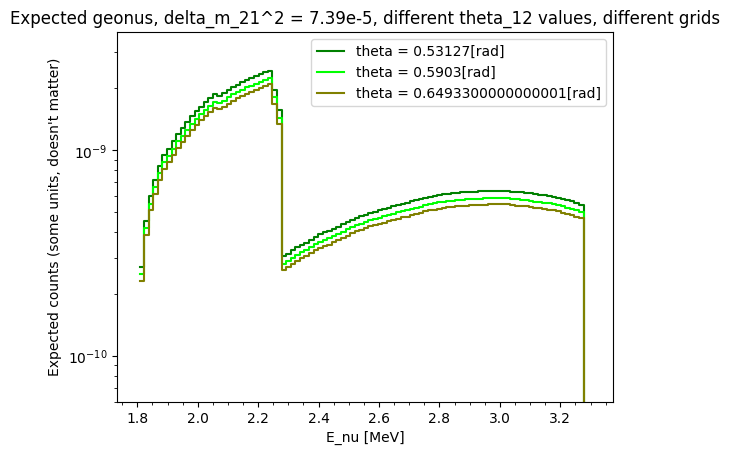

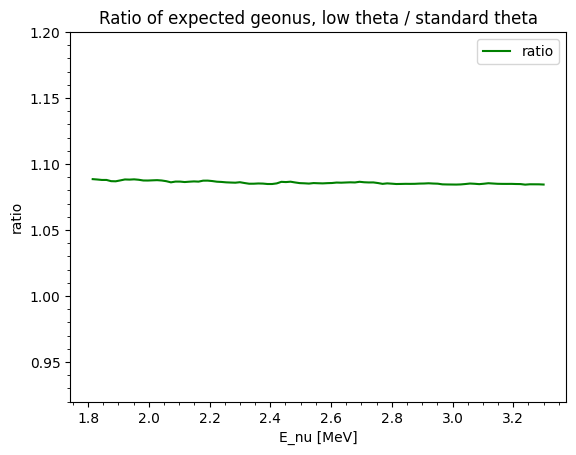

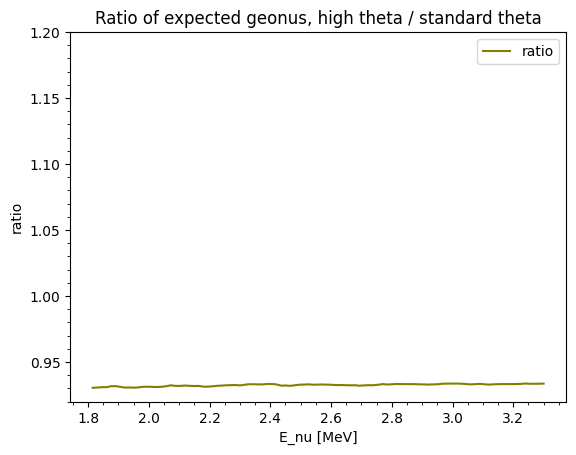

plots saved! yay!!


In [49]:

#plot comparisons
print("plot comparisons for different theta")
#plot to compare total for constant P_ee vs non-constant P_ee with standard osc parameters

plt.step(energy_array, N_U_theta_low_c + N_Th_theta_low_c + N_U_theta_low_m + N_Th_theta_low_m, where='mid', label=('theta = ' + str(theta_12_low) + '[rad]'), color='green')
plt.step(energy_array, N_U_c + N_Th_c + N_U_m + N_Th_m, where='mid', label='theta = 0.5903[rad]', color='lime')
plt.step(energy_array, N_U_theta_high_c + N_Th_theta_high_c + N_U_theta_high_m + N_Th_theta_high_m, where='mid', label=('theta = ' + str(theta_12_high) + '[rad]'), color='olive')


plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus, delta_m_21^2 = 7.39e-5, different theta_12 values, different grids')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=6e-11)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#standard delta m fluxes
plt.savefig('Expected geonu, standard delta m, Detailed Mantle.pdf', format='pdf')

plt.show()


plt.plot(energy_array, (N_U_theta_low_c + N_Th_theta_low_c + N_U_theta_low_m + N_Th_theta_low_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, low theta / standard theta')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)
# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
# standard delta m, low theta
plt.savefig('Ratio of expected geonu, standard delta m, low theta, Detailed Mantle.pdf', format='pdf')

plt.show()

plt.plot(energy_array, (N_U_theta_high_c + N_Th_theta_high_c + N_U_theta_high_m + N_Th_theta_high_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio', color='olive')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, high theta / standard theta')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)
# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#standard delta m, high theta
plt.savefig('Ratio of expected geonu, standard delta m, high theta, Detailed Mantle.pdf', format='pdf')

plt.show()

print("plots saved! yay!!")

In [50]:
print("moving on to different delta_m_21^2 for standard theta ... ")

print("computing contribution for low delta_m^2 (crust only)")
Th_integral_values_delta_m_low_c, U_integral_values_delta_m_low_c = integral_over_positions_Th_U(crust_grid, energy_array, grid_1d_size_crust, theta_12, delta_m_21_squared_low, A_Th_c, A_U_c, rho_c)

print("done!! moving on ... ")

moving on to different delta_m_21^2 for standard theta ... 
computing contribution for low delta_m^2 (crust only)
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
done!! moving on ... 


In [51]:
print("computing contribution for low delta_m^2 (CLM only)")
Th_integral_values_delta_m_low_CLM, U_integral_values_delta_m_low_CLM = integral_over_positions_Th_U(CLM_grid, energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_CLM, A_U_CLM, rho_CLM)

computing contribution for low delta_m^2 (CLM only)
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully


In [52]:
print("computing contribution for low delta_m^2 (DM only)")
Th_integral_values_delta_m_low_DM1, U_integral_values_delta_m_low_DM1 = integral_over_positions_Th_U(DM_grid1, energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM2, U_integral_values_delta_m_low_DM2 = integral_over_positions_Th_U(DM_grid2, energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM = Th_integral_values_delta_m_low_DM1 + Th_integral_values_delta_m_low_DM2

U_integral_values_delta_m_low_DM = U_integral_values_delta_m_low_DM1 + U_integral_values_delta_m_low_DM2

computing contribution for low delta_m^2 (DM only)
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully


In [53]:
print("computing contribution for low delta_m^2 (EM only)")
Th_integral_values_delta_m_low_EM, U_integral_values_delta_m_low_EM = integral_over_positions_Th_U(EM_grid, energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_EM, A_U_EM, rho_EM)


computing contribution for low delta_m^2 (EM only)
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully


In [54]:
Th_integral_values_delta_m_low_m = Th_integral_values_delta_m_low_CLM + Th_integral_values_delta_m_low_DM + Th_integral_values_delta_m_low_EM
U_integral_values_delta_m_low_m = U_integral_values_delta_m_low_CLM + U_integral_values_delta_m_low_DM + U_integral_values_delta_m_low_EM

In [55]:
print("total contribution done")

total contribution done


In [56]:
print("computing contribution for high delta_m^2 (crust only)")
Th_integral_values_delta_m_high_c, U_integral_values_delta_m_high_c = integral_over_positions_Th_U(crust_grid, energy_array, grid_1d_size_crust, theta_12, delta_m_21_squared_high, A_Th_c, A_U_c, rho_c)

print("done!! moving on ... ")


computing contribution for high delta_m^2 (crust only)
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
done!! moving on ... 


In [57]:
print("computing contribution for high delta_m^2 (CLM only)")
Th_integral_values_delta_m_high_CLM, U_integral_values_delta_m_high_CLM = integral_over_positions_Th_U(CLM_grid, energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_CLM, A_U_CLM, rho_CLM)


computing contribution for high delta_m^2 (CLM only)
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully


In [58]:
print("computing contribution for high delta_m^2 (DM only)")
Th_integral_values_delta_m_high_DM1, U_integral_values_delta_m_high_DM1 = integral_over_positions_Th_U(DM_grid1, energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM2, U_integral_values_delta_m_high_DM2 = integral_over_positions_Th_U(DM_grid2, energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM = Th_integral_values_delta_m_high_DM1 + Th_integral_values_delta_m_high_DM2

U_integral_values_delta_m_high_DM = U_integral_values_delta_m_high_DM1 + U_integral_values_delta_m_high_DM2


computing contribution for high delta_m^2 (DM only)
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully


In [59]:
print("computing contribution for high delta_m^2 (EM only)")
Th_integral_values_delta_m_high_EM, U_integral_values_delta_m_high_EM = integral_over_positions_Th_U(EM_grid, energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_EM, A_U_EM, rho_EM)


computing contribution for high delta_m^2 (EM only)
Relative distance array computed successfully
Delta_31 computed successfully
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully


In [60]:
Th_integral_values_delta_m_high_m = Th_integral_values_delta_m_high_CLM + Th_integral_values_delta_m_high_DM + Th_integral_values_delta_m_high_EM
U_integral_values_delta_m_high_m = U_integral_values_delta_m_high_CLM + U_integral_values_delta_m_high_DM + U_integral_values_delta_m_high_EM

print("total contribution done")

total contribution done


In [61]:
print("computing fluxes at detector location, low delta m^2")
N_Th_delta_m_low_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_delta_m_low_c
N_U_delta_m_low_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_delta_m_low_c

N_Th_delta_m_low_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_delta_m_low_m
N_U_delta_m_low_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_delta_m_low_m


computing fluxes at detector location, low delta m^2


In [62]:
print("computing fluxes at detector location, high delta m^2")
N_Th_delta_m_high_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_delta_m_high_c
N_U_delta_m_high_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_delta_m_high_c

N_Th_delta_m_high_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_delta_m_high_m
N_U_delta_m_high_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_delta_m_high_m


computing fluxes at detector location, high delta m^2


almost done! now making comparison plots ... 


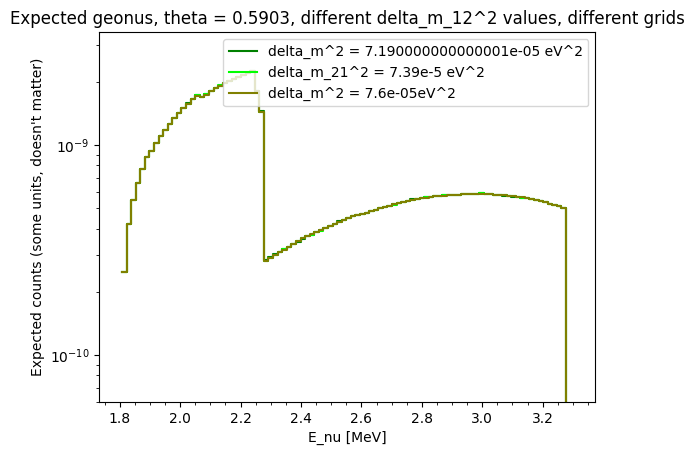

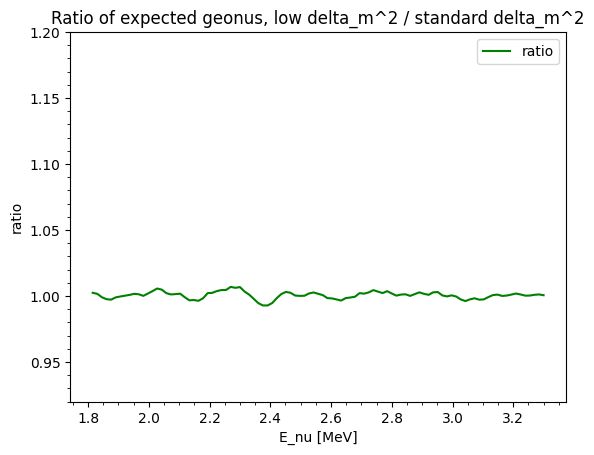

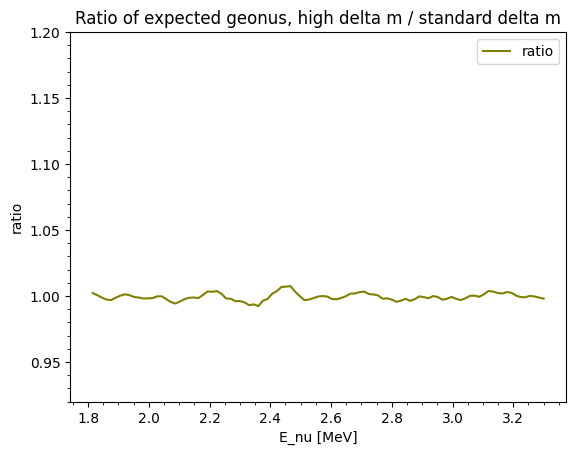

plots saved
   
All done! Congratulations!


In [63]:
print("almost done! now making comparison plots ... ")
#plot comparisons

#plot to compare total for constant P_ee vs non-constant P_ee with standard osc parameters

plt.step(energy_array, N_U_delta_m_low_c + N_Th_delta_m_low_c + N_U_delta_m_low_m + N_Th_delta_m_low_m, where='mid', label=('delta_m^2 = ' + str(delta_m_21_squared_low) + ' eV^2'), color='green')
plt.step(energy_array, N_U_c + N_Th_c + N_U_m + N_Th_m, where='mid', label='delta_m_21^2 = 7.39e-5 eV^2', color='lime')
plt.step(energy_array, N_U_delta_m_high_c + N_Th_delta_m_high_c + N_U_delta_m_high_m + N_Th_delta_m_high_m, where='mid', label=('delta_m^2 = ' + str(delta_m_21_squared_high) + 'eV^2'), color='olive')


plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus, theta = 0.5903, different delta_m_12^2 values, different grids')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=6e-11)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#standard theta fluxes
plt.savefig('Expected geonu, standard theta, Detailed Mantle.pdf', format='pdf')

plt.show()


plt.plot(energy_array, (N_U_delta_m_low_c + N_Th_delta_m_low_c + N_U_delta_m_low_m + N_Th_delta_m_low_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, low delta_m^2 / standard delta_m^2')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)
# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#standard theta, low delta m
plt.savefig('Ratio of expected geonu, standard theta, low delta m, Detailed Mantle.pdf', format='pdf')

plt.show()

plt.plot(energy_array, (N_U_delta_m_high_c + N_Th_delta_m_high_c + N_U_delta_m_high_m + N_Th_delta_m_high_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio', color='olive')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, high delta m / standard delta m')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)
# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#standard theta, high delta m
plt.savefig('Ratio of expected geonu, standard theta, high delta m, Detailed Mantle.pdf', format='pdf')

plt.show()

print("plots saved")

print("   ")

print("All done! Congratulations!")